### 데이터 읽기

In [1]:
import pandas as pd


In [2]:
messages = pd.read_csv('./spam.csv', encoding='latin-1')
messages.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
messages = messages.rename(columns={'v1': 'class', 'v2': 'text'})
messages.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 데이터 통계

In [4]:
messages.groupby('class').describe()

text                                                               
      count unique                                                top freq
class                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

### 데이터 길이 정보

In [5]:
messages['length'] = messages['text'].apply(len)
messages.head()

,class,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### spam은 문장의 길다?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DCF2A7AE88>,
      dtype=object)

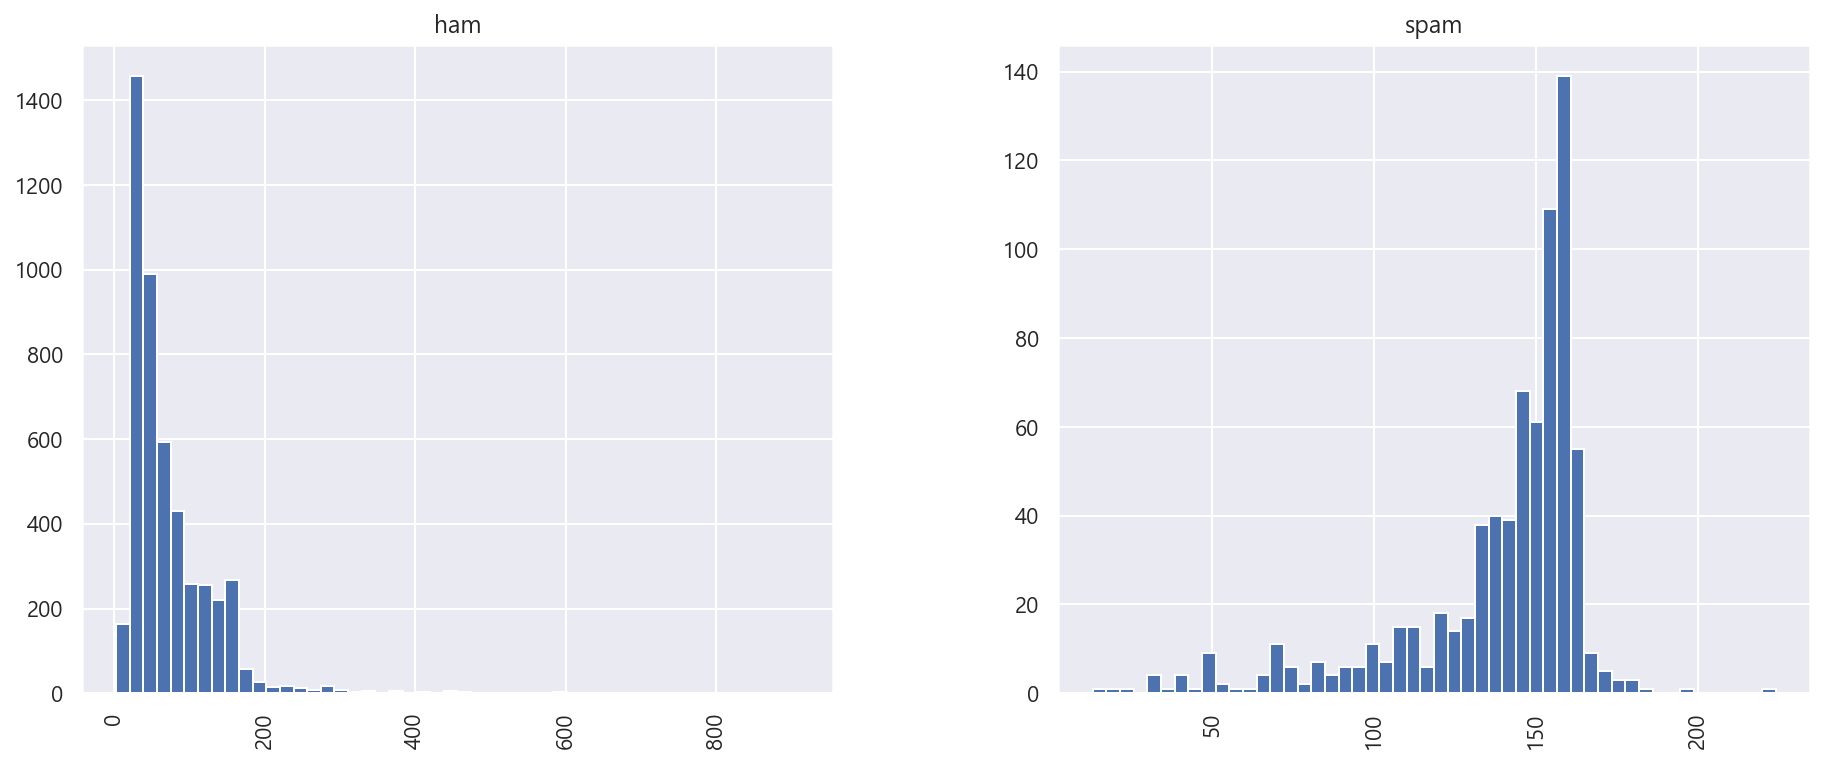

In [6]:
messages.hist(column='length', by='class', bins=50, figsize=(15,6))


### 단어 정리를 위한 함수

In [7]:
import string
from nltk.corpus import stopwords

def process_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = "".join(nopunc)
    
    clean_words = [word for word in nopunc.split() if 
                  word.lower() not in stopwords.words('english')]
    
    return clean_words

### 결과

In [8]:
messages['text'].apply(process_text).head()

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

### 데이터 분리

In [16]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, class_train, class_test = train_test_split(messages['text'],
                                                               messages['class'],
                                                               test_size=0.2)

### pipeline 구축

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=process_text)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

### 학습

In [18]:
pipeline.fit(msg_train, class_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer=<function process_text at 0x000001DCF4A5BA68>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### 결과

In [19]:
predictions = pipeline.predict(msg_test)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(class_test,predictions))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       949
        spam       1.00      0.70      0.83       166

    accuracy                           0.96      1115
   macro avg       0.98      0.85      0.90      1115
weighted avg       0.96      0.96      0.95      1115



### 간단한 시각화

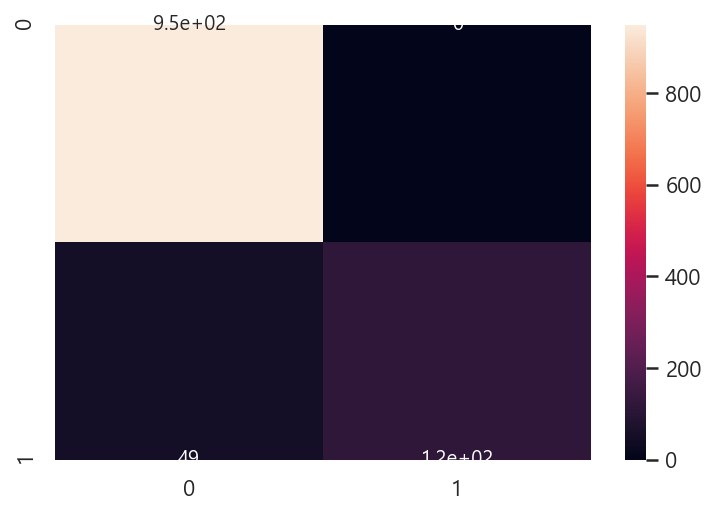

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(class_test, predictions), annot=True)

## 보너스

## 네이버 영화 평점을 이용한 감석분석

- 데이터셋 git hub주소(https://github.com/e9t/nsmc)


In [26]:
import pandas as pd

train_df = pd.read_csv('ratings_train.txt', sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


### 전체 데이터 분포 
    - 고르게 잘 분포 되어 있다

In [27]:
train_df['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

### train 데이터에서 숫자를 공백으로 매운다

In [28]:
import re
train_df = train_df.fillna(' ')

train_df['document'] = train_df['document'].apply(lambda x : re.sub(r"\d+", " ", x))

### test 데이터도 숫자를 공백으로 매운다

In [29]:
test_df = pd.read_csv('ratings_test.txt', sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply(lambda x : re.sub(r"\d+", " ", x))

### 형태소 분석

In [30]:
from konlpy.tag import Okt

okt = Okt()
def tw_tokenizer(text):
    tokens_ko = okt.morphs(text)
    return tokens_ko


### Tfidf를 사용

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3,max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

### LGBM 사용

In [35]:
from lightgbm import LGBMClassifier
import time

start_time = time.time()
lgbm_clf = LGBMClassifier(n_estimators=400)
lgbm_clf.fit(tfidf_matrix_train, train_df['label'])
print('Fit time : ', time.time() - start_time)

Fit time :  87.60899090766907


### Accuracy

In [36]:
from sklearn.metrics import accuracy_score

tfidf_matrix_test = tfidf_vect.transform(test_df['document'])
preds = lgbm_clf.predict(tfidf_matrix_test)

accuracy_score(test_df['label'], preds)


0.83038

### 문장 데스트

In [37]:
test_df['document'][100]

'걸작은 몇안되고 졸작들만 넘쳐난다.'

In [38]:
lgbm_clf.predict(tfidf_vect.transform([test_df['document'][100]]))

array([0], dtype=int64)

### 감성 분류 적용

In [39]:
lgbm_clf.predict(tfidf_vect.transform(['멋있다']))

array([1], dtype=int64)

In [40]:
lgbm_clf.predict(tfidf_vect.transform(['짜증나네']))

array([0], dtype=int64)

In [41]:
lgbm_clf.predict(tfidf_vect.transform(['괜찮다']))

array([1], dtype=int64)